In this sheet I will apply Convolutional Neural Networks for stock prediction of S&P500 index. I will divide data from last 20 years into chunks. Every day contains four values: opening, low, high and closing ones - therefore input data for 30-day chunk has size 30x4. Predicted output has three classes: whether stock will go up, down or stay constant X days after last input.

Story: Investor observes stock for 60 days. Then decides whether buy some stocks and sell it after 10 days. Therefore input consist of stock prices from day 1st to 60th, output is:
* -1 if price will go down by more than 1%, 
* 0 if price will not go up or down by more than 1% 
* 1 if price will go up by more than 1%

Relative change output is calculated using the following formula: (opening_price_on_buyout_day -closing_price_on_last_day_of_observation) / opening_price_on_buyout_day * 100%

Based on percentage value from formula above, label will be calculated.

In [12]:
import pandas as pd

df = pd.read_csv('./data/sp500_20Y_with_covid.csv')
df.reindex(index=df.index[::-1])

df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-02-22,1346.089966,1358.109985,1331.880005,1352.170044,1352.170044,980000000
1,2000-02-23,1352.170044,1370.109985,1342.439941,1360.689941,1360.689941,993700000
2,2000-02-24,1360.689941,1364.800049,1329.880005,1353.430054,1353.430054,1215000000
3,2000-02-25,1353.430054,1362.140015,1329.150024,1333.359985,1333.359985,1065200000
4,2000-02-28,1333.359985,1360.819946,1325.069946,1348.050049,1348.050049,1026500000


In [54]:
def percentage_to_label(percentage_value):
    return -1 if percentage_value < -1 else 0 if percentage_value <= 1 else 1

def investor_observes_stocks_for(x_days=60, then_buy_stocks=True, and_sells_them=True, after_y_days=10, dataframe=df):
    assert then_buy_stocks
    assert and_sells_them
    observe_buy_sell_process_length = x_days + after_y_days
    
    observed_chunks = []
    observation_results = []
    
    for first_day_of_observation in range(len(dataframe) - observe_buy_sell_process_length):
        buyout_day = first_day_of_observation + x_days
        sell_day = buyout_day + after_y_days
        
        observed_chunk = dataframe[first_day_of_observation:buyout_day].reset_index()
        observation_result = dataframe.iloc[sell_day]
        
        closing_price_on_buyout_day = dataframe.iloc[buyout_day]['Close']
        opening_price_on_sell_day = dataframe.iloc[sell_day]['Open']
        
        relative_price_change_as_percentage = (opening_price_on_sell_day - closing_price_on_buyout_day) / closing_price_on_buyout_day * 100
        
        observed_chunks += [observed_chunk]
        observation_results += [percentage_to_label(relative_price_change_as_percentage)]
    
    return observed_chunks, observation_results

observed_chunks, observation_results = investor_observes_stocks_for(x_days=60, then_buy_stocks=True, and_sells_them=True, after_y_days=10)

In [60]:
observed_chunks[0].head(10)

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2000-02-22,1346.089966,1358.109985,1331.880005,1352.170044,1352.170044,980000000
1,1,2000-02-23,1352.170044,1370.109985,1342.439941,1360.689941,1360.689941,993700000
2,2,2000-02-24,1360.689941,1364.800049,1329.880005,1353.430054,1353.430054,1215000000
3,3,2000-02-25,1353.430054,1362.140015,1329.150024,1333.359985,1333.359985,1065200000
4,4,2000-02-28,1333.359985,1360.819946,1325.069946,1348.050049,1348.050049,1026500000
5,5,2000-02-29,1348.050049,1369.630005,1348.050049,1366.420044,1366.420044,1204300000
6,6,2000-03-01,1366.420044,1383.459961,1366.420044,1379.189941,1379.189941,1274100000
7,7,2000-03-02,1379.189941,1386.560059,1370.349976,1381.760010,1381.760010,1198600000
8,8,2000-03-03,1381.760010,1410.880005,1381.760010,1409.170044,1409.170044,1150300000
9,9,2000-03-06,1409.170044,1409.739990,1384.750000,1391.280029,1391.280029,1029000000


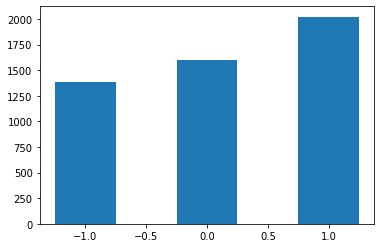

In [61]:
import matplotlib.pyplot as plt

plt.hist(observation_results, bins=[-1.25, -0.75, -0.25, 0.25, 0.75, 1.25])
plt.show()

**IMPORTANT NOTE** Selecting test/valiations chunks randomly from the whole set of observation chunks seems to be a big mistake. It causes situation where network actually seen chunks from the future, therefore the more overfitted network, the better results will be. Network should be trained incrementally - with data from time x to x+1 and validated with data from x+1 to x+2. Then learned with data from x to x+2 and validated with data from x+3 to x+3 and so on..

In [81]:
import numpy as np
from keras.utils import to_categorical

def categorical_labels(label_array):
    return to_categorical(list(map(lambda x: x + 1, label_array)))

categorical_labels(observation_results)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [123]:
from keras import models
from keras.models import Sequential
from keras.layers import Convolution1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.layers.core import Dense, Dropout, Activation, Flatten

model = Sequential()
model.add(Convolution1D(input_shape = (60, 5), filters=16, kernel_size=4, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Convolution1D(filters=8, kernel_size=4, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dense(3))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 60, 16)            336       
_________________________________________________________________
batch_normalization_18 (Batc (None, 60, 16)            64        
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 60, 16)            0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 60, 16)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 60, 8)             520       
_________________________________________________________________
batch_normalization_19 (Batc (None, 60, 8)             32        
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 60, 8)           

In [126]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [116]:
X = np.array(list(map(lambda df: df[['Open', 'High', 'Low', 'Close', 'Adj Close']].to_numpy(), observed_chunks)))
Y = np.array(categorical_labels(observation_results))

training_test_split_index = 3 * len(observed_chunks)//4
X_train = X[:training_test_split_index]
Y_train = Y[:training_test_split_index]
X_test = X[training_test_split_index:]
Y_test = Y[training_test_split_index:]

In [118]:
X_train.shape, Y_train.shape

((3752, 60, 5), (3752, 3))

In [129]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=30, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="model.hdf5", verbose=1, save_best_only=True)

history = model.fit(x=X_train, 
                    y=Y_train, 
                    batch_size=64, 
                    epochs=500, 
                    validation_data=(X_test, Y_test),
                    callbacks = [reduce_lr, checkpointer])

Train on 3752 samples, validate on 1251 samples
Epoch 1/500
3752/3752 [==============================] - 0s 108us/step - loss: 1.0371 - accuracy: 0.4664 - val_loss: 1.8721 - val_accuracy: 0.3973
Epoch 2/500
3752/3752 [==============================] - 0s 91us/step - loss: 1.0389 - accuracy: 0.4643 - val_loss: 1.8379 - val_accuracy: 0.3989
Epoch 3/500
3752/3752 [==============================] - 0s 98us/step - loss: 1.0382 - accuracy: 0.4611 - val_loss: 1.7364 - val_accuracy: 0.2910
Epoch 4/500
3752/3752 [==============================] - 0s 96us/step - loss: 1.0411 - accuracy: 0.4614 - val_loss: 2.1307 - val_accuracy: 0.3957
Epoch 5/500
3752/3752 [==============================] - 0s 104us/step - loss: 1.0363 - accuracy: 0.4576 - val_loss: 2.7779 - val_accuracy: 0.3933
Epoch 6/500
3752/3752 [==============================] - 0s 91us/step - loss: 1.0318 - accuracy: 0.4875 - val_loss: 1.5195 - val_accuracy: 0.3965
Epoch 7/500
3752/3752 [==============================] - 0s 96us/step - lo

3752/3752 [==============================] - 0s 97us/step - loss: 1.0178 - accuracy: 0.4891 - val_loss: 1.4444 - val_accuracy: 0.2118
Epoch 57/500
3752/3752 [==============================] - 0s 95us/step - loss: 1.0171 - accuracy: 0.4912 - val_loss: 1.4691 - val_accuracy: 0.4285
Epoch 58/500
3752/3752 [==============================] - 0s 97us/step - loss: 1.0168 - accuracy: 0.4856 - val_loss: 1.3854 - val_accuracy: 0.2446
Epoch 59/500
3752/3752 [==============================] - 0s 93us/step - loss: 1.0183 - accuracy: 0.4960 - val_loss: 1.2716 - val_accuracy: 0.4197
Epoch 60/500
3752/3752 [==============================] - 0s 91us/step - loss: 1.0200 - accuracy: 0.4875 - val_loss: 1.2347 - val_accuracy: 0.3965
Epoch 61/500
3752/3752 [==============================] - 0s 91us/step - loss: 1.0188 - accuracy: 0.4784 - val_loss: 4.7047 - val_accuracy: 0.3885
Epoch 62/500
3752/3752 [==============================] - 0s 90us/step - loss: 1.0166 - accuracy: 0.4952 - val_loss: 1.2084 - val_a

Epoch 112/500
3752/3752 [==============================] - 0s 99us/step - loss: 1.0011 - accuracy: 0.5043 - val_loss: 1.9634 - val_accuracy: 0.4053
Epoch 113/500
3752/3752 [==============================] - 0s 91us/step - loss: 0.9989 - accuracy: 0.5091 - val_loss: 2.1555 - val_accuracy: 0.4045
Epoch 114/500
3752/3752 [==============================] - 0s 96us/step - loss: 0.9983 - accuracy: 0.5093 - val_loss: 3.3213 - val_accuracy: 0.3909
Epoch 115/500
3752/3752 [==============================] - 0s 93us/step - loss: 1.0051 - accuracy: 0.4931 - val_loss: 1.3784 - val_accuracy: 0.4061
Epoch 116/500
3752/3752 [==============================] - 0s 91us/step - loss: 0.9920 - accuracy: 0.5069 - val_loss: 1.2248 - val_accuracy: 0.3813
Epoch 117/500
3752/3752 [==============================] - 0s 98us/step - loss: 1.0064 - accuracy: 0.4933 - val_loss: 1.2124 - val_accuracy: 0.4388
Epoch 118/500
3752/3752 [==============================] - 0s 93us/step - loss: 1.0023 - accuracy: 0.4992 - val_

3752/3752 [==============================] - 0s 94us/step - loss: 0.9839 - accuracy: 0.5187 - val_loss: 1.4053 - val_accuracy: 0.4221
Epoch 168/500
3752/3752 [==============================] - 0s 92us/step - loss: 0.9736 - accuracy: 0.5288 - val_loss: 1.4550 - val_accuracy: 0.4261
Epoch 169/500
3752/3752 [==============================] - 0s 89us/step - loss: 0.9809 - accuracy: 0.5195 - val_loss: 1.2791 - val_accuracy: 0.4349
Epoch 170/500
3752/3752 [==============================] - 0s 95us/step - loss: 0.9809 - accuracy: 0.5128 - val_loss: 2.2141 - val_accuracy: 0.4005
Epoch 171/500
3752/3752 [==============================] - 0s 91us/step - loss: 0.9802 - accuracy: 0.5101 - val_loss: 1.3693 - val_accuracy: 0.4061
Epoch 172/500
3752/3752 [==============================] - 0s 90us/step - loss: 0.9833 - accuracy: 0.5157 - val_loss: 2.2849 - val_accuracy: 0.4061
Epoch 173/500
3752/3752 [==============================] - 0s 91us/step - loss: 0.9700 - accuracy: 0.5307 - val_loss: 1.4143 -

3752/3752 [==============================] - 0s 117us/step - loss: 0.9626 - accuracy: 0.5365 - val_loss: 1.7544 - val_accuracy: 0.4245
Epoch 223/500
3752/3752 [==============================] - 0s 111us/step - loss: 0.9584 - accuracy: 0.5269 - val_loss: 1.4441 - val_accuracy: 0.4197
Epoch 224/500
3752/3752 [==============================] - 0s 111us/step - loss: 0.9577 - accuracy: 0.5482 - val_loss: 3.2905 - val_accuracy: 0.3925
Epoch 225/500
3752/3752 [==============================] - 0s 105us/step - loss: 0.9623 - accuracy: 0.5312 - val_loss: 1.3657 - val_accuracy: 0.4173
Epoch 226/500
3752/3752 [==============================] - 0s 106us/step - loss: 0.9645 - accuracy: 0.5280 - val_loss: 3.0148 - val_accuracy: 0.3981
Epoch 227/500
3752/3752 [==============================] - 0s 106us/step - loss: 0.9676 - accuracy: 0.5229 - val_loss: 1.4391 - val_accuracy: 0.4269
Epoch 228/500
3752/3752 [==============================] - 0s 101us/step - loss: 0.9520 - accuracy: 0.5413 - val_loss: 1

3752/3752 [==============================] - 0s 125us/step - loss: 0.9454 - accuracy: 0.5413 - val_loss: 2.1069 - val_accuracy: 0.4165
Epoch 278/500
3752/3752 [==============================] - 0s 107us/step - loss: 0.9490 - accuracy: 0.5506 - val_loss: 1.8777 - val_accuracy: 0.4037
Epoch 279/500
3752/3752 [==============================] - 0s 111us/step - loss: 0.9459 - accuracy: 0.5429 - val_loss: 1.3509 - val_accuracy: 0.4229
Epoch 280/500
3752/3752 [==============================] - 0s 103us/step - loss: 0.9427 - accuracy: 0.5482 - val_loss: 1.5698 - val_accuracy: 0.3949
Epoch 281/500
3752/3752 [==============================] - 1s 134us/step - loss: 0.9304 - accuracy: 0.5602 - val_loss: 2.7123 - val_accuracy: 0.4013
Epoch 282/500
3752/3752 [==============================] - 0s 125us/step - loss: 0.9439 - accuracy: 0.5485 - val_loss: 9.1572 - val_accuracy: 0.3861
Epoch 283/500
3752/3752 [==============================] - 0s 132us/step - loss: 0.9451 - accuracy: 0.5352 - val_loss: 1

3752/3752 [==============================] - 0s 88us/step - loss: 0.9248 - accuracy: 0.5600 - val_loss: 1.5707 - val_accuracy: 0.4229
Epoch 333/500
3752/3752 [==============================] - 0s 88us/step - loss: 0.9348 - accuracy: 0.5472 - val_loss: 2.3140 - val_accuracy: 0.4157
Epoch 334/500
3752/3752 [==============================] - 0s 88us/step - loss: 0.9234 - accuracy: 0.5552 - val_loss: 1.8520 - val_accuracy: 0.4061
Epoch 335/500
3752/3752 [==============================] - 0s 92us/step - loss: 0.9221 - accuracy: 0.5618 - val_loss: 1.6708 - val_accuracy: 0.4157
Epoch 336/500
3752/3752 [==============================] - 0s 88us/step - loss: 0.9169 - accuracy: 0.5602 - val_loss: 2.2672 - val_accuracy: 0.3893
Epoch 337/500
3752/3752 [==============================] - 0s 97us/step - loss: 0.9267 - accuracy: 0.5562 - val_loss: 1.9559 - val_accuracy: 0.4101
Epoch 338/500
3752/3752 [==============================] - 0s 88us/step - loss: 0.9239 - accuracy: 0.5650 - val_loss: 1.5461 -

3752/3752 [==============================] - 0s 90us/step - loss: 0.9208 - accuracy: 0.5730 - val_loss: 7.4549 - val_accuracy: 0.3869
Epoch 388/500
3752/3752 [==============================] - 0s 94us/step - loss: 0.9156 - accuracy: 0.5648 - val_loss: 1.3244 - val_accuracy: 0.4133
Epoch 389/500
3752/3752 [==============================] - 0s 88us/step - loss: 0.8990 - accuracy: 0.5922 - val_loss: 3.7483 - val_accuracy: 0.3669
Epoch 390/500
3752/3752 [==============================] - 0s 88us/step - loss: 0.9131 - accuracy: 0.5728 - val_loss: 1.3422 - val_accuracy: 0.3429
Epoch 391/500
3752/3752 [==============================] - 0s 93us/step - loss: 0.9067 - accuracy: 0.5730 - val_loss: 1.4929 - val_accuracy: 0.3805
Epoch 392/500
3752/3752 [==============================] - 0s 90us/step - loss: 0.9091 - accuracy: 0.5696 - val_loss: 1.4797 - val_accuracy: 0.3357
Epoch 393/500
3752/3752 [==============================] - 0s 90us/step - loss: 0.9029 - accuracy: 0.5749 - val_loss: 4.1744 -

3752/3752 [==============================] - 0s 110us/step - loss: 0.8892 - accuracy: 0.5864 - val_loss: 1.4702 - val_accuracy: 0.3605
Epoch 443/500
3752/3752 [==============================] - 0s 90us/step - loss: 0.8994 - accuracy: 0.5794 - val_loss: 1.7860 - val_accuracy: 0.4221
Epoch 444/500
3752/3752 [==============================] - 0s 108us/step - loss: 0.8879 - accuracy: 0.5922 - val_loss: 1.8840 - val_accuracy: 0.3485
Epoch 445/500
3752/3752 [==============================] - 0s 93us/step - loss: 0.8967 - accuracy: 0.5914 - val_loss: 2.0936 - val_accuracy: 0.3189
Epoch 446/500
3752/3752 [==============================] - 0s 88us/step - loss: 0.8837 - accuracy: 0.5866 - val_loss: 5.4169 - val_accuracy: 0.3821
Epoch 447/500
3752/3752 [==============================] - 0s 87us/step - loss: 0.8972 - accuracy: 0.5898 - val_loss: 1.6386 - val_accuracy: 0.4173
Epoch 448/500
3752/3752 [==============================] - 0s 88us/step - loss: 0.8879 - accuracy: 0.5872 - val_loss: 3.4051

3752/3752 [==============================] - 0s 90us/step - loss: 0.8827 - accuracy: 0.5949 - val_loss: 1.9636 - val_accuracy: 0.4285
Epoch 498/500
3752/3752 [==============================] - 0s 84us/step - loss: 0.8814 - accuracy: 0.5970 - val_loss: 2.8744 - val_accuracy: 0.3253
Epoch 499/500
3752/3752 [==============================] - 0s 85us/step - loss: 0.8763 - accuracy: 0.5930 - val_loss: 4.2828 - val_accuracy: 0.3941
Epoch 500/500
3752/3752 [==============================] - 0s 89us/step - loss: 0.8763 - accuracy: 0.5946 - val_loss: 1.7589 - val_accuracy: 0.3997


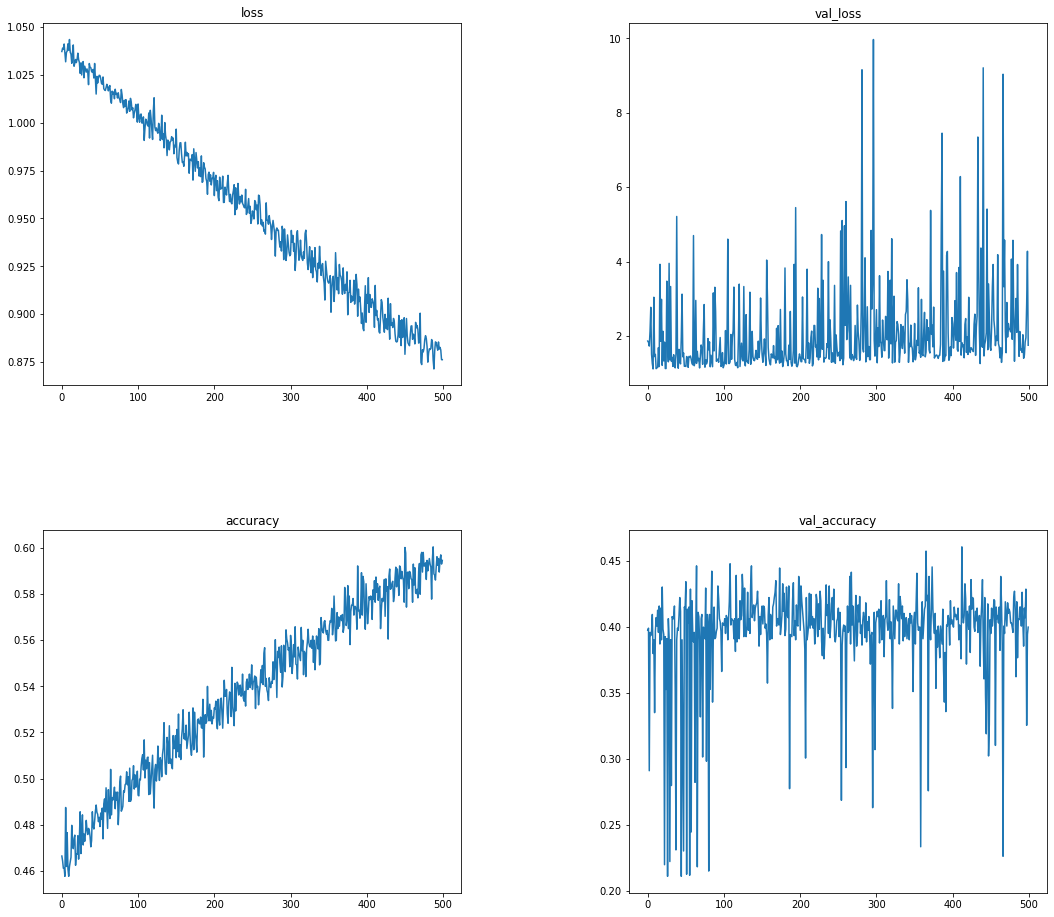

In [130]:
history_dict = history.history
history_dict.keys()

fig = plt.figure(figsize=(18, 16))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

plt.subplot(2, 2, 1)
plt.title('loss')
plt.plot(history_dict['loss'])
plt.subplot(2, 2, 2)
plt.title('val_loss')
plt.plot(history_dict['val_loss'])
plt.subplot(2, 2, 3)
plt.title('accuracy')
plt.plot(history_dict['accuracy'])
plt.subplot(2, 2, 4)
plt.title('val_accuracy')
plt.plot(history_dict['val_accuracy'])

plt.show()